In [ ]:
!pip install agentpy
import agentpy as ap

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import IPython
import random as rand

matplotlib.rcParams['animation.embed_limit'] = 2**128

In [ ]:
class InfectionModel(ap.Model):

    def setup(self):
        #create agents (Persons)
        nPersons = int(self.p['Population Density'] * (self.p.size**2))
        persons = self.agents = ap.AgentList(self, nPersons)

        #create grid (local area)
        self.city = ap.Grid(self, [self.p.size]*2, track_empty=True)
        self.city.add_agents(persons, random=True, empty=True)

        #Dynamic variable for all persons
        # Condition {0: Susceptible, 1: recently infected, 2: infected, 3: recovered}
        self.agents.condition = 0

        #Set patient(s) zero
        self.agents.random(self.p['Initial Infected']).condition = 1

        self.timeStep = 0

    def update(self):
        pop = 0
        for i in range(0,5):
            pop += len(self.agents.select(self.agents.condition == i))
        self['S'] = len(self.agents.select(self.agents.condition == 0))/pop
        self['I'] = (len(self.agents.select(self.agents.condition == 1)) + len(self.agents.select(self.agents.condition == 2)))/pop
        self['R'] = len(self.agents.select(self.agents.condition == 3))/pop
        self['V'] = len(self.agents.select(self.agents.condition == 4))/pop
        self.record('S')
        self.record('I')
        self.record('R')
        self.record('V')

    def step(self):

        self.timeStep += 1

        # select infected population
        infected_Population = self.agents.select(self.agents.condition == 1)
        infected_Population += self.agents.select(self.agents.condition == 2)
        recently_Infected = self.agents.select(self.agents.condition == 1)
        recovered_Population = self.agents.select(self.agents.condition == 3)

        vaccinated_Population = self.agents.select(self.agents.condition == 0)
        vaccinated_Population += self.agents.select(self.agents.condition == 3)

        # spread infection
        for inf in infected_Population:
            for neighbor in self.city.neighbors(inf):
                if neighbor.condition == 0:
                    if rand.uniform(0,1) < self.p['Infection Probability']:
                        neighbor.condition = 1

        # move recently infected to regular infected
        for inf in recently_Infected:
            inf.condition = 2

        # recover infection
        for inf in infected_Population:
            if rand.uniform(0,1) < self.p['Recovery Probability']:
                inf.condition = 3

        # Loss of natural immunity
        for rec in recovered_Population:
            if rand.uniform(0,1) < self.p['Resusceptibility Probability']:
                rec.condition = 0

        # vaccination
        if self.timeStep >= self.p['Vaccination Start']:
          if len(vaccinated_Population) > self.p['Vaccination Speed']:
            vaccinated_Population.random(self.p['Vaccination Speed']).condition = 4
          else:
            vaccinated_Population.condition = 4

        # stop sim if no infected left
        if(len(infected_Population) == 0):
            self.stop()

    def end(self):

        #Document a measure at the end of the simulation
        recovered_Population = len(self.agents.select(self.agents.condition == 2))
        self.report('Percentage of recovered population', recovered_Population / len(self.agents))

In [ ]:
# Define Parameters
parameters = {
    'Population Density':0.65,
    'size': 50,
    'steps': 500,
    'Initial Infected': 3,
    'Infection Probability': 0.3,
    'Recovery Probability': 0.1,
    'Resusceptibility Probability': 0.02,
    'Vaccination Speed': 20,
    'Vaccination Start': 200
}

Completed: 303 steps
Run time: 0:00:02.607637
Simulation finished


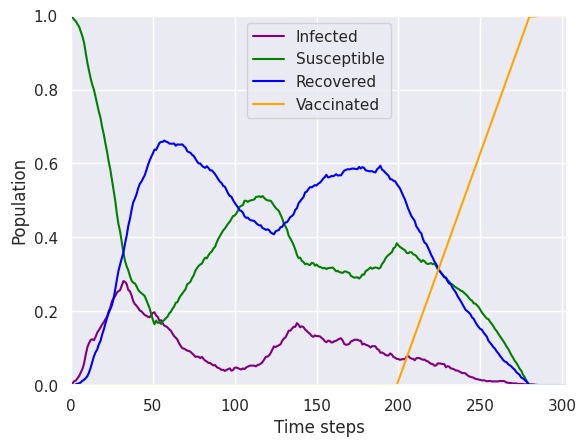

In [ ]:
def virus_lineplot(data, ax):
    x = data.index.get_level_values('t')
    y = [data[var] for var in ['I', 'S', 'R', 'V']]

    ax.plot(x,y[0], 'purple', label = "Infected")
    ax.plot(x,y[1], 'green', label = "Susceptible")
    ax.plot(x,y[2], 'blue', label = "Recovered")
    ax.plot(x,y[3], 'orange', label = "Vaccinated")

    ax.legend()
    ax.set_xlim(0, max(1, len(x)-1))
    ax.set_ylim(0, 1)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Population")


model = InfectionModel(parameters)
results = model.run()
fig, ax = plt.subplots()
virus_lineplot(results.variables.InfectionModel, ax)

Completed: 312 steps
Run time: 0:00:02.719044
Simulation finished


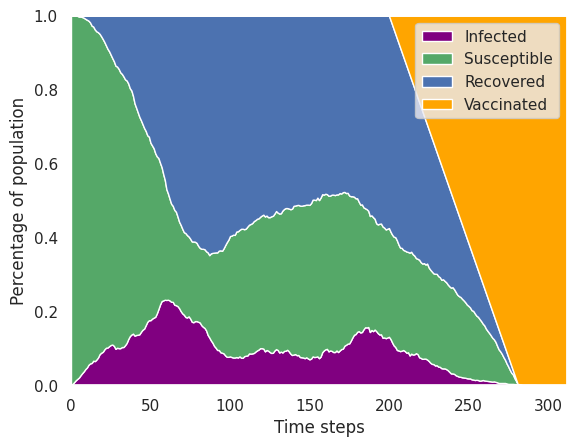

In [ ]:
def virus_stackplot(data, ax):
    """ Stackplot of people's condition over time. """
    x = data.index.get_level_values('t')
    y = [data[var] for var in ['I', 'S', 'R', 'V']]

    sns.set()
    ax.stackplot(x, y, labels=['Infected', 'Susceptible', 'Recovered', 'Vaccinated'],
                 colors = ['purple', 'g', 'b', 'orange'])

    ax.legend()
    ax.set_xlim(0, max(1, len(x)-1))
    ax.set_ylim(0, 1)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Percentage of population")

model = InfectionModel(parameters)
results = model.run()
fig, ax = plt.subplots()
virus_stackplot(results.variables.InfectionModel, ax)

## Description

The graph representing the vaccinated population increases linearly starting timestep 200. Its increase happens simultaneous with the decrease of infected, susceptible, and recovered agents.

The first simulation ends at timestep 279; the second ends at 273. They end because there are no infecteds left. At these timesteps, 100% of the population is vaccinated.

# Vaccination speed to 0

0% of the population is vaccinated. Each of the populations for the rest of the statuses (susceptibles, infecteds, and recovereds) fluctuate. This is seen in how the graphs for the susceptible, infected, and recovered populations increase and decrease continuously, but more or less stay within the same range of values throughout (except for the start of the simulation, where the susceptible population drops and the recovered population rises). This simulation ends at timestep 500, but there are still infecteds in the population. It only ends because the maximum number of steps for the simulation is 500.